# Comparison to Colossus

This notebook compares `halox` implementations against the [`colossus`](https://bdiemer.bitbucket.io/colossus/index.html) library to validate the accuracy of our calculations.
Each comparison illustrate how to use `halox` to compute properties that are also present in `colossus`, and shows the agreement between the two libraries and their relative differences.

**Note:** These comparison are implemented as unit tests in the GitHub repository; see [Tests workflow](https://github.com/fkeruzore/halox/actions/workflows/tests.yml).

In [2]:
import jax
import jax.numpy as jnp
import jax.scipy.integrate as jspint
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# halox imports
from halox import cosmology, nfw, hmf, lss, bias, einasto

# colossus imports
from colossus.halo import profile_nfw, profile_einasto, mass_defs
from colossus.lss import mass_function, peaks, bias as colossus_bias
import colossus.cosmology.cosmology as cc
from colossus.utils.constants import G as Gcol
print(Gcol)

#gala for potentials
import gala.potential.potential as gp
from gala.units import galactic

jax.config.update("jax_enable_x64", True) # double precision is, th

print(plt.style.available)
plt.style.use(["seaborn-v0_8-darkgrid", "ggplot"])
plt.rcParams.update({"xtick.direction": "in", "ytick.direction": "in"})

/Users/lamoreau/halox/.venv/lib/python3.9/site-packages/jax_cosmo/__init__.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound


4.300917270038e-06
['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


We'll use a consistent cosmology for both libraries:

In [3]:
# Setup cosmologies for both libraries
# Primary cosmology: Planck18
cosmo_halox_planck = cosmology.Planck18()
cc.addCosmology(  # not taking base planck18 because it differs sightly
    "my_planck18",
    params={
        "flat": True,
        "H0": 100 * cosmo_halox_planck.h,
        "Om0": cosmo_halox_planck.Omega_m,
        "Ob0": cosmo_halox_planck.Omega_b,
        "sigma8": cosmo_halox_planck.sigma8,
        "ns": cosmo_halox_planck.n_s,
    },
)
cosmo_colossus_planck = "my_planck18"

# Alternative cosmology: Flamingo's LS8
cosmo_halox_alt = cosmology.Planck18(
    h=0.682,
    Omega_c=0.305 - 0.0473,
    Omega_b=0.0473,
    sigma8=0.76,
    n_s=0.965,
)

cc.setCosmology(cosmo_colossus_planck)
cc.addCosmology(
    "low_s8",
    params={
        "flat": True,
        "H0": 100 * cosmo_halox_alt.h,
        "Om0": cosmo_halox_alt.Omega_m,
        "Ob0": cosmo_halox_alt.Omega_b,
        "sigma8": cosmo_halox_alt.sigma8,
        "ns": cosmo_halox_alt.n_s,
    },
)
cosmo_colossus_alt = "low_s8"

In [4]:
def create_comparison_plot():
    fig = plt.figure()
    gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1], hspace=0.05)
    ax_main = fig.add_subplot(gs[0])
    ax_ratio = fig.add_subplot(gs[1], sharex=ax_main)

    # Remove x-axis labels from main panel
    ax_main.tick_params(labelbottom=False)

    # Style both panels
    for ax in [ax_main, ax_ratio]:
        ax.xaxis.set_ticks_position("both")
        ax.yaxis.set_ticks_position("both")
        ax.grid(True, alpha=1.0)

    return fig, ax_main, ax_ratio


style_kw = [
    dict(color="C1", ls="-", lw=1.5, zorder=1),
    dict(color="C0", ls="--", lw=2.5, zorder=2),
    dict(color="C3", ls="-", lw=1.5, zorder=1),
    dict(color="C2", ls="--", lw=2.5, zorder=2),
    dict(color="C5", ls="-", lw=1.5, zorder=1),
    dict(color="C4", ls=":", lw=2.5, zorder=2),
    dict(color="C0", ls="-", lw=2.5, zorder=2),
    dict(color="C2", ls="-", lw=2.5, zorder=2),
    dict(color="C4", ls=":", lw=2.5, zorder=2),
]

## NFW Profile Comparisons

### NFW Density Profile

% diff at z=0:  [5.54956081e-10 5.46473977e-10 5.36259925e-10 5.23936450e-10
 5.09436937e-10 4.92339503e-10 4.72533124e-10 4.49884574e-10
 4.24504876e-10 3.96593869e-10 3.66395803e-10 3.34599015e-10
 3.01847436e-10 2.68940425e-10 2.36766162e-10 2.05857553e-10
 1.77036164e-10 1.50701673e-10 1.27076127e-10 1.06203935e-10
 8.81739126e-11 7.26751992e-11 5.96633853e-11 4.87387908e-11
 3.96571664e-11 3.21520588e-11 2.59792188e-11 2.10054196e-11
 1.68975944e-11 1.35891298e-11 1.09467990e-11 8.79296636e-12]
% diff at z=2:  [-0.04728879 -0.04589926 -0.04427361 -0.04239718 -0.04026469 -0.03788361
 -0.03527677 -0.03248359 -0.02955893 -0.02656963 -0.02358865 -0.02068817
 -0.01793276 -0.01537401 -0.01304761 -0.01097275 -0.00915376 -0.00758294
 -0.00624399 -0.00511531 -0.00417275 -0.00339178 -0.00274888 -0.00222247
 -0.00179332 -0.00144472 -0.00116237 -0.00093422 -0.00075021 -0.00060203
 -0.00048286 -0.0003871 ]


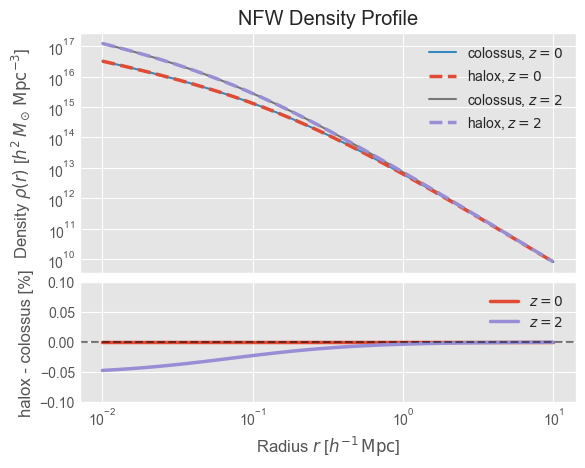

In [5]:
# Halo parameters
m_delta = 1e14  # h-1 Msun
c_delta = 5.0
deltas = [200.0]
redshifts = [0.0, 2.0]

# Radial range
r = jnp.logspace(-2, 1, 32)  # h-1 Mpc

# Compute density profiles for both redshifts
rho_halox = {}
rho_colossus = {}

for z in redshifts:
    nfw_halox = nfw.NFWHalo(
        m_delta, c_delta, z, cosmo_halox_planck, delta=deltas[0]
    )
    nfw_colossus = profile_nfw.NFWProfile(
        M=m_delta, c=c_delta, z=z, mdef=f"{deltas[0]:.0f}c"
    )

    rho_halox[z] = nfw_halox.density(r)
    rho_colossus[z] = nfw_colossus.density(r * 1000) * 1e9

# Create comparison plot
fig, ax_main, ax_ratio = create_comparison_plot()

# Main panel: plot colossus first (behind), then halox (on top)
# z=0.0
ax_main.loglog(r, rho_colossus[0.0], label="colossus, $z=0$", **style_kw[0])
ax_main.loglog(r, rho_halox[0.0], label="halox, $z=0$", **style_kw[1])

# z=2.0
ax_main.loglog(r, rho_colossus[2.0], label="colossus, $z=2$", **style_kw[2])
ax_main.loglog(r, rho_halox[2.0], label="halox, $z=2$", **style_kw[3])

ax_main.set_ylabel(r"Density $\rho(r)$ [$h^2 \, M_\odot \, {\rm Mpc}^{-3}$]")
ax_main.set_title("NFW Density Profile")
ax_main.legend()

# Ratio panel: relative differences for both redshifts
ratio_z0 = (rho_halox[0.0] / rho_colossus[0.0] - 1.0) * 100  # Convert to %
ratio_z1 = (rho_halox[2.0] / rho_colossus[2.0] - 1.0) * 100  # Convert to %

ax_ratio.semilogx(r, ratio_z0, label="$z=0$", **style_kw[-3])
ax_ratio.semilogx(r, ratio_z1, label="$z=2$", **style_kw[-2])

ax_ratio.axhline(0.0, color="k", linestyle="--", alpha=0.5)
ax_ratio.set_xlabel(r"Radius $r$ [$h^{-1} \, {\rm Mpc}$]")
ax_ratio.set_ylabel("halox - colossus [%]")
ax_ratio.set_ylim(-0.1, 0.1)
ax_ratio.legend()

# Align y-axis labels
fig.align_labels([ax_main, ax_ratio])

print("% diff at z=0: ", ratio_z0)
print("% diff at z=2: ", ratio_z1)

### NFW Enclosed Mass

% diff at z=0:  [5.70321568e-10 5.61417579e-10 5.52868862e-10 5.48272538e-10
 5.35860245e-10 5.25091082e-10 5.11080067e-10 4.95203878e-10
 4.77351492e-10 4.56990001e-10 4.35451675e-10 4.12048173e-10
 3.87512245e-10 3.62199160e-10 3.36730643e-10 3.11617399e-10
 2.87281310e-10 2.64077649e-10 2.42228460e-10 2.22044605e-10
 2.03548289e-10 1.86717308e-10 1.71462844e-10 1.57740487e-10
 1.45528034e-10 1.34536826e-10 1.24722455e-10 1.15951693e-10
 1.08113518e-10 1.01074704e-10 9.47686374e-11 8.90620910e-11]
% diff at z=2:  [-0.0494174  -0.04846782 -0.04735034 -0.04605117 -0.04456176 -0.04288102
 -0.04101732 -0.03898971 -0.03682789 -0.03457066 -0.03226294 -0.02995185
 -0.02768251 -0.02549441 -0.02341893 -0.02147827 -0.01968551 -0.01804577
 -0.01655774 -0.01521541 -0.01400967 -0.01292966 -0.01196376 -0.01110038
 -0.01032838 -0.00963741 -0.00901802 -0.00846173 -0.00796098 -0.00750913
 -0.00710036 -0.00672954]


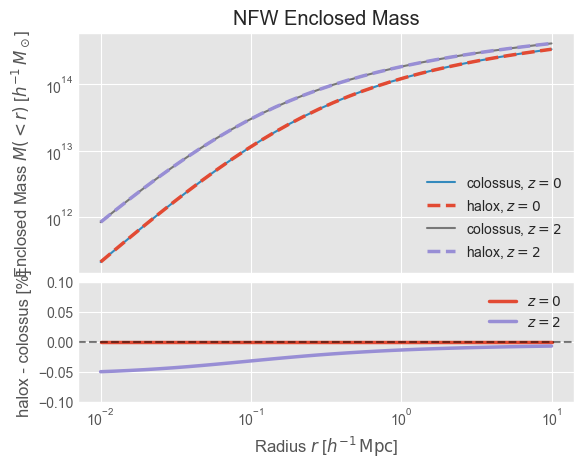

In [6]:
# Compute enclosed mass profiles for both redshifts
mass_halox = {}
mass_colossus = {}

for z in redshifts:
    nfw_halox = nfw.NFWHalo(
        m_delta, c_delta, z, cosmo_halox_planck, delta=deltas[0]
    )
    nfw_colossus = profile_nfw.NFWProfile(
        M=m_delta, c=c_delta, z=z, mdef=f"{deltas[0]:.0f}c"
    )

    mass_halox[z] = nfw_halox.enclosed_mass(r)
    mass_colossus[z] = nfw_colossus.enclosedMass(r * 1000)

# Create comparison plot
fig, ax_main, ax_ratio = create_comparison_plot()

# Main panel: plot colossus first (behind), then halox (on top)
# z=0.0
ax_main.loglog(r, mass_colossus[0.0], label="colossus, $z=0$", **style_kw[0])
ax_main.loglog(r, mass_halox[0.0], label="halox, $z=0$", **style_kw[1])

# z=2.0
ax_main.loglog(r, mass_colossus[2.0], label="colossus, $z=2$", **style_kw[2])
ax_main.loglog(r, mass_halox[2.0], label="halox, $z=2$", **style_kw[3])

ax_main.set_ylabel(r"Enclosed Mass $M(<r)$ [$h^{-1} \, M_\odot$]")
ax_main.set_title("NFW Enclosed Mass")
ax_main.legend()

# Ratio panel: relative differences for both redshifts
ratio_z0 = (mass_halox[0.0] / mass_colossus[0.0] - 1.0) * 100  # Convert to %
ratio_z1 = (mass_halox[2.0] / mass_colossus[2.0] - 1.0) * 100  # Convert to %

ax_ratio.semilogx(r, ratio_z0, label="$z=0$", **style_kw[-3])
ax_ratio.semilogx(r, ratio_z1, label="$z=2$", **style_kw[-2])

ax_ratio.axhline(0.0, color="k", linestyle="--", alpha=0.5)
ax_ratio.set_xlabel(r"Radius $r$ [$h^{-1} \, {\rm Mpc}$]")
ax_ratio.set_ylabel("halox - colossus [%]")
ax_ratio.set_ylim(-0.1, 0.1)
ax_ratio.legend()

# Align y-axis labels
fig.align_labels([ax_main, ax_ratio])

print("% diff at z=0: ", ratio_z0)
print("% diff at z=2: ", ratio_z1)

### NFW Surface Density

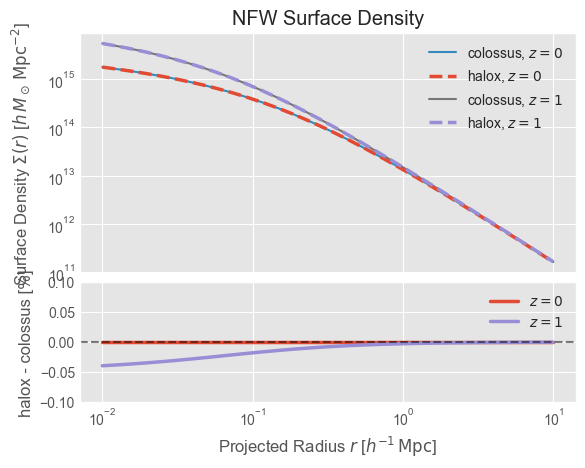

In [7]:
# Compute surface density profiles for both redshifts
sigma_surf_halox = {}
sigma_surf_colossus = {}

for z in redshifts:
    nfw_halox = nfw.NFWHalo(
        m_delta, c_delta, z, cosmo_halox_planck, delta=deltas[0]
    )
    nfw_colossus = profile_nfw.NFWProfile(
        M=m_delta, c=c_delta, z=z, mdef=f"{deltas[0]:.0f}c"
    )

    sigma_surf_halox[z] = nfw_halox.surface_density(r)
    sigma_surf_colossus[z] = nfw_colossus.surfaceDensity(r * 1000) * 1e6

# Create comparison plot
fig, ax_main, ax_ratio = create_comparison_plot()

# Main panel: plot colossus first (behind), then halox (on top)
# z=0.0
ax_main.loglog(
    r, sigma_surf_colossus[0.0], label="colossus, $z=0$", **style_kw[0]
)
ax_main.loglog(r, sigma_surf_halox[0.0], label="halox, $z=0$", **style_kw[1])

# z=2.0
ax_main.loglog(
    r, sigma_surf_colossus[2.0], label="colossus, $z=1$", **style_kw[2]
)
ax_main.loglog(r, sigma_surf_halox[2.0], label="halox, $z=1$", **style_kw[3])

ax_main.set_ylabel(
    r"Surface Density $\Sigma(r)$ [$h \, M_\odot \, {\rm Mpc}^{-2}$]"
)
ax_main.set_title("NFW Surface Density")
ax_main.legend()

# Ratio panel: relative differences for both redshifts
ratio_z0 = (
    sigma_surf_halox[0.0] / sigma_surf_colossus[0.0] - 1.0
) * 100  # Convert to %
ratio_z1 = (
    sigma_surf_halox[2.0] / sigma_surf_colossus[2.0] - 1.0
) * 100  # Convert to %

ax_ratio.semilogx(r, ratio_z0, label="$z=0$", **style_kw[-3])
ax_ratio.semilogx(r, ratio_z1, label="$z=1$", **style_kw[-2])

ax_ratio.axhline(0.0, color="k", linestyle="--", alpha=0.5)
ax_ratio.set_xlabel(r"Projected Radius $r$ [$h^{-1} \, {\rm Mpc}$]")
ax_ratio.set_ylabel("halox - colossus [%]")
ax_ratio.set_ylim(-0.1, 0.1)
ax_ratio.legend()

# Align y-axis labels
fig.align_labels([ax_main, ax_ratio])

### NFW Circular Velocity

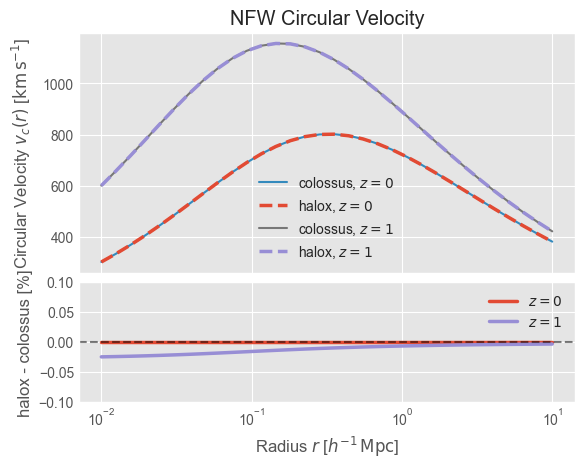

In [8]:
# Compute circular velocity profiles for both redshifts
v_c_halox = {}
v_c_colossus = {}

for z in redshifts:
    nfw_halox = nfw.NFWHalo(
        m_delta, c_delta, z, cosmo_halox_planck, delta=deltas[0]
    )
    nfw_colossus = profile_nfw.NFWProfile(
        M=m_delta, c=c_delta, z=z, mdef=f"{deltas[0]:.0f}c"
    )

    v_c_halox[z] = nfw_halox.circular_velocity(r)
    v_c_colossus[z] = nfw_colossus.circularVelocity(r * 1000)

# Create comparison plot
fig, ax_main, ax_ratio = create_comparison_plot()

# Main panel: plot colossus first (behind), then halox (on top)
# z=0.0
ax_main.semilogx(r, v_c_colossus[0.0], label="colossus, $z=0$", **style_kw[0])
ax_main.semilogx(r, v_c_halox[0.0], label="halox, $z=0$", **style_kw[1])

# z=2.0
ax_main.semilogx(r, v_c_colossus[2.0], label="colossus, $z=1$", **style_kw[2])
ax_main.semilogx(r, v_c_halox[2.0], label="halox, $z=1$", **style_kw[3])

ax_main.set_ylabel(r"Circular Velocity $v_c(r)$ [${\rm km} \, {\rm s}^{-1}$]")
ax_main.set_title("NFW Circular Velocity")
ax_main.legend()

# Ratio panel: relative differences for both redshifts
ratio_z0 = (v_c_halox[0.0] / v_c_colossus[0.0] - 1.0) * 100  # Convert to %
ratio_z1 = (v_c_halox[2.0] / v_c_colossus[2.0] - 1.0) * 100  # Convert to %

ax_ratio.semilogx(r, ratio_z0, label="$z=0$", **style_kw[-3])
ax_ratio.semilogx(r, ratio_z1, label="$z=1$", **style_kw[-2])

ax_ratio.axhline(0.0, color="k", linestyle="--", alpha=0.5)
ax_ratio.set_xlabel(r"Radius $r$ [$h^{-1} \, {\rm Mpc}$]")
ax_ratio.set_ylabel("halox - colossus [%]")
ax_ratio.set_ylim(-0.1, 0.1)
ax_ratio.legend()

# Align y-axis labels
fig.align_labels([ax_main, ax_ratio])

### NFW Potential

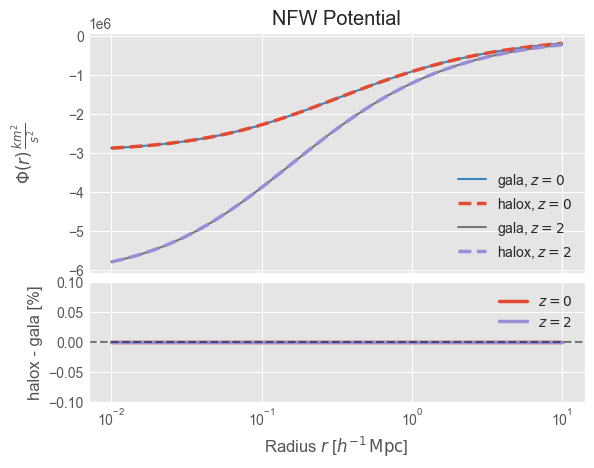

In [9]:
import astropy.units as u
import numpy as np
phi_gala = {}
phi_halox = {}
phi_haloxe = {}

kmperkpc = 30856775999999956
secpermyr = 3.15576e13
confactor = kmperkpc**2 / secpermyr**2
#print(confactor) #conversion from kpc^2 per Myr^2 to km^2 per s^2

for z in redshifts:
    haloxhalo = nfw.NFWHalo(m_delta, c_delta, z, cosmo_halox_planck)
    m = (m_delta / (np.log(1+c_delta)-c_delta/(1+c_delta))) * u.Msun
    r_s = haloxhalo.r_delta * 1000 / c_delta * u.kpc #converting r_delta to kpc
    galahalo = gp.NFWPotential(m=m, r_s=r_s, units = galactic)

    r_kpc = r * 1000 * u.kpc  # if r was in Mpc
    xyz = np.zeros((3, len(r_kpc))) * u.kpc
    xyz[0] = r_kpc
    phi_halox[z] = haloxhalo.potential(r)
    # phi_haloxe[z] = haloxeinasto.potential(r)
    phi_gala[z] = galahalo.energy(xyz).value * confactor

# Create comparison plot
fig, ax_main, ax_ratio = create_comparison_plot()

# Main panel: plot colossus first (behind), then halox (on top)
# z=0.0
ax_main.semilogx(r, phi_gala[0.0], label="gala, $z=0$", **style_kw[0])
ax_main.semilogx(r, phi_halox[0.0], label="halox, $z=0$", **style_kw[1])

# z=2.0
ax_main.semilogx(r, phi_gala[2.0], label="gala, $z=2$", **style_kw[2])
ax_main.semilogx(r, phi_halox[2.0], label="halox, $z=2$", **style_kw[3])

ax_main.set_ylabel(r"$\Phi(r)\, \frac{km^2}{s^2}$")
ax_main.set_title("NFW Potential")
ax_main.legend()

# Ratio panel: relative differences for both redshifts
ratio_z0 = (phi_halox[0.0] / phi_gala[0.0] - 1.0) * 100  # Convert to %
ratio_z1 = (phi_halox[2.0] / phi_gala[2.0] - 1.0) * 100  # Convert to %

ax_ratio.semilogx(r, ratio_z0, label="$z=0$", **style_kw[-3])
ax_ratio.semilogx(r, ratio_z1, label="$z=2$", **style_kw[-2])

ax_ratio.axhline(0.0, color="k", linestyle="--", alpha=0.5)
ax_ratio.set_xlabel(r"Radius $r$ [$h^{-1} \, {\rm Mpc}$]")
ax_ratio.set_ylabel("halox - gala [%]")
ax_ratio.set_ylim(-0.1, 0.1)
ax_ratio.legend()

# Align y-axis labels
fig.align_labels([ax_main, ax_ratio])

# Einasto Profile Comparison

### Einasto Density Profile

% diff at z=0:  [ 8.39373016e-10  8.37596659e-10  8.35709280e-10  8.33777491e-10
  8.31867908e-10  8.29758484e-10  8.27582447e-10  8.25450819e-10
  8.23119350e-10  8.20765678e-10  8.18300983e-10  8.15725265e-10
  8.13082934e-10  8.10329581e-10  8.07487410e-10  8.04512013e-10
  8.01492206e-10  7.98294764e-10  7.95008503e-10  7.91589017e-10
  7.88036303e-10  7.84372567e-10  7.80575604e-10  7.76623210e-10
  7.72493181e-10  7.68252129e-10  7.63877850e-10  7.59303731e-10
  7.54596385e-10  7.49666995e-10  7.44559969e-10  7.39297512e-10
  7.33857419e-10  7.28128668e-10  7.22266691e-10  7.16204873e-10
  7.09809989e-10  7.03281877e-10  6.96442903e-10  6.89448498e-10
  6.82143231e-10  6.74504896e-10  6.66622313e-10  6.58539889e-10
  6.50013376e-10  6.41264819e-10  6.32160990e-10  6.22790708e-10
  6.12976336e-10  6.02784489e-10  5.92303984e-10  5.81468207e-10
  5.70121728e-10  5.58375568e-10  5.46274137e-10  5.33662003e-10
  5.20605781e-10  5.07016651e-10  4.92916818e-10  4.78372897e-10
  4.63273

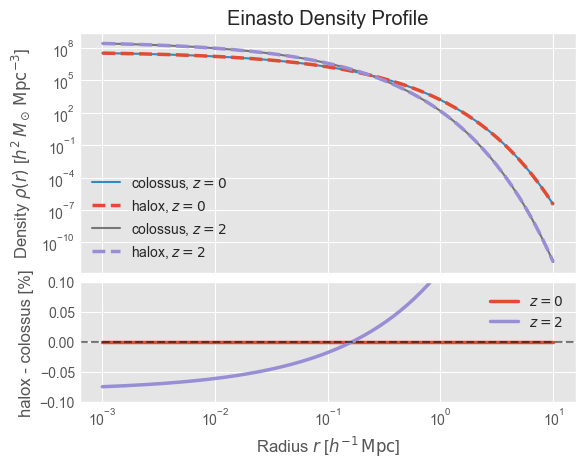

In [10]:
# Halo parameters
m_delta = 1e14  # h-1 Msun
c_delta = 5.0
alpha = 0.5
deltas = [200.0]
redshifts = [0.0, 2.0]

# Radial range
r = jnp.logspace(-3, 1, 128)  # h-1 Mpc

# Compute density profiles for both redshifts
rho_halox = {}
rho_colossus = {}
Mtokpc = 1e9
for z in redshifts:
    einasto_halox = einasto.EinastoHalo(
        m_delta, c_delta, z, alpha, cosmo_halox_planck, delta=deltas[0]
    )
    einasto_colossus = profile_einasto.EinastoProfile(
        M=m_delta, c=c_delta, z=z, mdef=f"{deltas[0]:.0f}c", alpha=alpha
    )

    rho_halox[z] = einasto_halox.density(r) / 1e9 #convert from Mpc to kpc units to match colossus
    rho_colossus[z] = einasto_colossus.density(r * 1000)

# Create comparison plot
fig, ax_main, ax_ratio = create_comparison_plot()

# Main panel: plot colossus first (behind), then halox (on top)
# z=0.0
ax_main.loglog(r, rho_colossus[0.0], label="colossus, $z=0$", **style_kw[0])
ax_main.loglog(r, rho_halox[0.0], label="halox, $z=0$", **style_kw[1])

# z=1.0
ax_main.loglog(r, rho_colossus[2.0], label="colossus, $z=2$", **style_kw[2])
ax_main.loglog(r, rho_halox[2.0], label="halox, $z=2$", **style_kw[3])

ax_main.set_ylabel(r"Density $\rho(r)$ [$h^2 \, M_\odot \, {\rm Mpc}^{-3}$]")
ax_main.set_title("Einasto Density Profile")
ax_main.legend()

# Ratio panel: relative differences for both redshifts
ratio_z0 = (rho_halox[0.0] / rho_colossus[0.0] - 1.0) * 100  # Convert to %
ratio_z1 = (rho_halox[2.0] / rho_colossus[2.0] - 1.0) * 100  # Convert to %

ax_ratio.semilogx(r, ratio_z0, label="$z=0$", **style_kw[-3])
ax_ratio.semilogx(r, ratio_z1, label="$z=2$", **style_kw[-2])

ax_ratio.axhline(0.0, color="k", linestyle="--", alpha=0.5)
ax_ratio.set_xlabel(r"Radius $r$ [$h^{-1} \, {\rm Mpc}$]")
ax_ratio.set_ylabel("halox - colossus [%]")
ax_ratio.set_ylim(-0.1, 0.1)
ax_ratio.legend()

# Align y-axis labels
fig.align_labels([ax_main, ax_ratio])

print("% diff at z=0: ", ratio_z0)
print("% diff at z=2: ", ratio_z1)

### Einasto Enclosed Mass

% diff at z=0:  [ 8.46411830e-10  8.44946335e-10  8.43258796e-10  8.41926528e-10
  8.39905923e-10  8.38507042e-10  8.36686276e-10  8.34954328e-10
  8.32778291e-10  8.30624458e-10  8.28914715e-10  8.26472224e-10
  8.24229573e-10  8.22186763e-10  8.19433410e-10  8.17279577e-10
  8.14570633e-10  8.11817280e-10  8.09219358e-10  8.06221756e-10
  8.03335176e-10  8.00337574e-10  7.97073518e-10  7.93809463e-10
  7.90345567e-10  7.86926080e-10  7.83217935e-10  7.79376563e-10
  7.75579601e-10  7.71382958e-10  7.67297337e-10  7.62900854e-10
  7.58393348e-10  7.53930252e-10  7.48934248e-10  7.44049267e-10
  7.38875627e-10  7.33524352e-10  7.27951033e-10  7.22266691e-10
  7.16338100e-10  7.10231873e-10  7.03903602e-10  6.97331082e-10
  6.90603130e-10  6.83630930e-10  6.76414480e-10  6.68864963e-10
  6.61315447e-10  6.53255228e-10  6.45083986e-10  6.36624087e-10
  6.27875529e-10  6.18771701e-10  6.09534645e-10  5.99920114e-10
  5.89994720e-10  5.79780668e-10  5.69411185e-10  5.58575408e-10
  5.47428

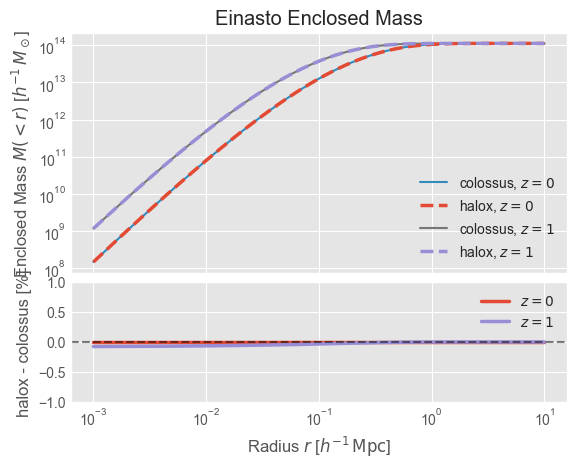

In [11]:
# Compute enclosed mass profiles for both redshifts
mass_halox = {}
mass_colossus = {}

for z in redshifts:
    einasto_halox = einasto.EinastoHalo(
        m_delta, c_delta, z, alpha, cosmo_halox_planck, delta=deltas[0]
    )
    einasto_colossus = profile_einasto.EinastoProfile(
        M=m_delta, c=c_delta, z=z, mdef=f"{deltas[0]:.0f}c", alpha=alpha
    )

    mass_halox[z] = einasto_halox.enclosed_mass(r)
    mass_colossus[z] = einasto_colossus.enclosedMass(r * 1000)

# Create comparison plot
fig, ax_main, ax_ratio = create_comparison_plot()

# Main panel: plot colossus first (behind), then halox (on top)
# z=0.0
ax_main.loglog(r, mass_colossus[0.0], label="colossus, $z=0$", **style_kw[0])
ax_main.loglog(r, mass_halox[0.0], label="halox, $z=0$", **style_kw[1])

# z=2.0
ax_main.loglog(r, mass_colossus[2.0], label="colossus, $z=1$", **style_kw[2])
ax_main.loglog(r, mass_halox[2.0], label="halox, $z=1$", **style_kw[3])

ax_main.set_ylabel(r"Enclosed Mass $M(<r)$ [$h^{-1} \, M_\odot$]")
ax_main.set_title("Einasto Enclosed Mass")
ax_main.legend()

# Ratio panel: relative differences for both redshifts
ratio_z0 = (mass_halox[0.0] / mass_colossus[0.0] - 1.0) * 100  # Convert to %
ratio_z1 = (mass_halox[2.0] / mass_colossus[2.0] - 1.0) * 100  # Convert to %

ax_ratio.semilogx(r, ratio_z0, label="$z=0$", **style_kw[-3])
ax_ratio.semilogx(r, ratio_z1, label="$z=1$", **style_kw[-2])

ax_ratio.axhline(0.0, color="k", linestyle="--", alpha=0.5)
ax_ratio.set_xlabel(r"Radius $r$ [$h^{-1} \, {\rm Mpc}$]")
ax_ratio.set_ylabel("halox - colossus [%]")
ax_ratio.set_ylim(-1, 1)
ax_ratio.legend()

# Align y-axis labels
fig.align_labels([ax_main, ax_ratio])

print("% diff at z=0: ", ratio_z0)
print("% diff at z=2: ", ratio_z1)

### Einasto Circular Velocity

% diff at z=0:  [-1.85629290e-11 -1.93067784e-11 -2.01505479e-11 -2.08055795e-11
 -2.18158824e-11 -2.25153229e-11 -2.34479103e-11 -2.42916798e-11
 -2.53908006e-11 -2.64566147e-11 -2.73225886e-11 -2.85327317e-11
 -2.96540570e-11 -3.06643599e-11 -3.20632410e-11 -3.31401573e-11
 -3.44835271e-11 -3.58713059e-11 -3.71813691e-11 -3.86801702e-11
 -4.01123579e-11 -4.15889545e-11 -4.32431868e-11 -4.48863169e-11
 -4.66071626e-11 -4.82835993e-11 -5.01820807e-11 -5.20916643e-11
 -5.39901457e-11 -5.60773650e-11 -5.81312776e-11 -6.03295192e-11
 -6.25721697e-11 -6.48148202e-11 -6.73128220e-11 -6.97442104e-11
 -7.23532345e-11 -7.50066675e-11 -7.77933273e-11 -8.06466005e-11
 -8.36108960e-11 -8.66529071e-11 -8.98281449e-11 -9.31033028e-11
 -9.64894831e-11 -9.99644811e-11 -1.03572706e-10 -1.07347464e-10
 -1.11111120e-10 -1.15141230e-10 -1.19249055e-10 -1.23456800e-10
 -1.27831079e-10 -1.32382993e-10 -1.37001521e-10 -1.41808787e-10
 -1.46782586e-10 -1.51889612e-10 -1.57074354e-10 -1.62503344e-10
 -1.68054

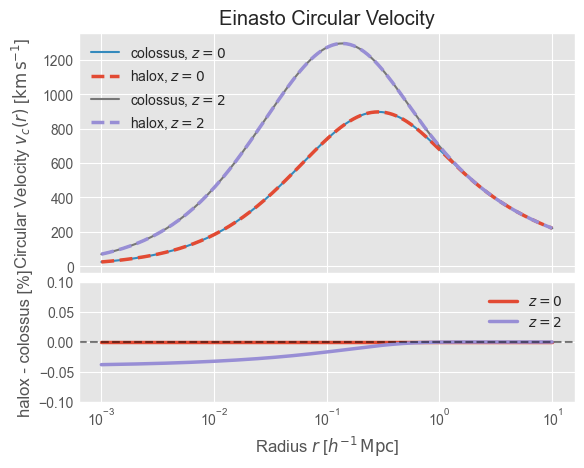

In [12]:
# Compute circular velocity profiles for both redshifts
v_c_halox = {}
v_c_colossus = {}

for z in redshifts:
    einasto_halox = einasto.EinastoHalo(
        m_delta, c_delta, z, alpha, cosmo_halox_planck, delta=deltas[0]
    )
    einasto_colossus = profile_einasto.EinastoProfile(
        M=m_delta, c=c_delta, z=z, mdef=f"{deltas[0]:.0f}c", alpha = alpha
    )

    v_c_halox[z] = einasto_halox.circular_velocity(r)
    v_c_colossus[z] = einasto_colossus.circularVelocity(r * 1000)

# Create comparison plot
fig, ax_main, ax_ratio = create_comparison_plot()

# Main panel: plot colossus first (behind), then halox (on top)
# z=0.0
ax_main.semilogx(r, v_c_colossus[0.0], label="colossus, $z=0$", **style_kw[0])
ax_main.semilogx(r, v_c_halox[0.0], label="halox, $z=0$", **style_kw[1])

# z=2.0
ax_main.semilogx(r, v_c_colossus[2.0], label="colossus, $z=2$", **style_kw[2])
ax_main.semilogx(r, v_c_halox[2.0], label="halox, $z=2$", **style_kw[3])

ax_main.set_ylabel(r"Circular Velocity $v_c(r)$ [${\rm km} \, {\rm s}^{-1}$]")
ax_main.set_title("Einasto Circular Velocity")
ax_main.legend()

# Ratio panel: relative differences for both redshifts
ratio_z0 = (v_c_halox[0.0] / v_c_colossus[0.0] - 1.0) * 100  # Convert to %
ratio_z1 = (v_c_halox[2.0] / v_c_colossus[2.0] - 1.0) * 100  # Convert to %

ax_ratio.semilogx(r, ratio_z0, label="$z=0$", **style_kw[-3])
ax_ratio.semilogx(r, ratio_z1, label="$z=2$", **style_kw[-2])

ax_ratio.axhline(0.0, color="k", linestyle="--", alpha=0.5)
ax_ratio.set_xlabel(r"Radius $r$ [$h^{-1} \, {\rm Mpc}$]")
ax_ratio.set_ylabel("halox - colossus [%]")
ax_ratio.set_ylim(-0.1, 0.1)
ax_ratio.legend()

# Align y-axis labels
fig.align_labels([ax_main, ax_ratio])

print("% diff at z=0: ", ratio_z0)
print("% diff at z=2: ", ratio_z1)

In [ ]:
from scipy.integrate import quad

def einasto_potential_numeric(r, halo, r_max):
    """
    halo: a colossus halo
    """
    G = 4.30091e-6  # (kpc/h) (km/s)^2 / (Msun/h)
    r = np.atleast_1d(r)

    def outer_term(r):
        integrand = lambda rp: halo.enclosedMass(rp) / rp**2
        return np.array([quad(integrand, ri, r_max)[0] for ri in r])

    #phi = -G * (halo.enclosedMass(r) / r + outer_term(r))
    phi = -G * outer_term(r)
    return phi

### Einasto Potential

% diff at z=0:  [0.00266941 0.00266946 0.00266951 0.00266957 0.00266964 0.00266972
 0.00266981 0.00266991 0.00267003 0.00267016 0.00267031 0.00267049
 0.00267068 0.00267091 0.00267116 0.00267145 0.00267178 0.00267216
 0.00267258 0.00267307 0.00267361 0.00267423 0.00267494 0.00267573
 0.00267663 0.00267765 0.00267879 0.00268008 0.00268154 0.00268318
 0.00268503 0.0026871  0.00268943 0.00269205 0.00269498 0.00269827
 0.00270195 0.00270606 0.00271065 0.00271578 0.0027215  0.00272786
 0.00273495 0.00274282 0.00275157 0.00276127 0.00277203 0.00278394
 0.00279711 0.00281168 0.00282776 0.00284551 0.00286507 0.00288662
 0.00291033 0.00293641 0.00296506 0.00299653 0.00303106 0.00306893
 0.00311044 0.00315592 0.00320571 0.00326021 0.00331984 0.00338505
 0.00345635 0.00353429 0.00361946 0.00371253 0.00381421 0.00392529
 0.00404662 0.00417915 0.00432391 0.00448202 0.0046547  0.00484331
 0.00504929 0.00527423 0.00551986 0.00578805 0.00608082 0.00640035
 0.00674899 0.00712924 0.00754382 0.0079956  0

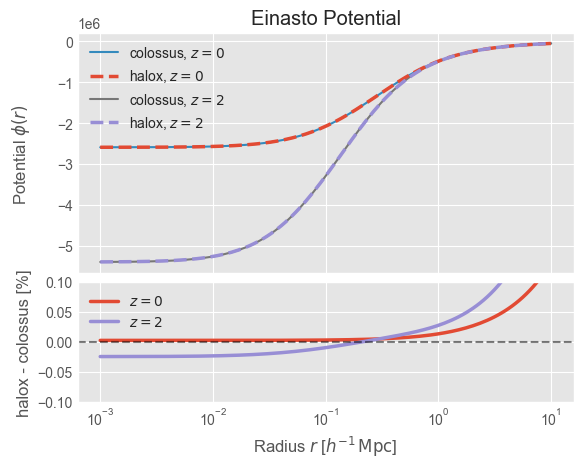

In [ ]:
phi_col = {}
phi_halox = {}
phi_nfw = {}
for z in redshifts:
    einasto_halox = einasto.EinastoHalo(
        m_delta, c_delta, z, alpha, cosmo_halox_planck, delta=deltas[0]
    )
    einasto_colossus = profile_einasto.EinastoProfile(
        M=m_delta, c=c_delta, z=z, mdef=f"{deltas[0]:.0f}c", alpha = alpha
    )
    nfw_h = nfw.NFWHalo(m_delta, c_delta, z, cosmo_halox_planck)
    einasto_colossus.setNativeParameters(m_delta, c_delta, z, mdef=f"{deltas[0]:.0f}c", alpha = alpha)
    f = 1e4
    phi_col[z] = einasto_potential_numeric(r*1000, einasto_colossus, r_max = f * einasto_colossus.RDelta(z, mdef=f"{deltas[0]:.0f}c"))
    phi_halox[z] = einasto_halox.potential(r)
    phi_nfw[z] = nfw_h.potential(r)
# Create comparison plot
fig, ax_main, ax_ratio = create_comparison_plot()

# Main panel: plot colossus first (behind), then halox (on top)
# z=0.0
ax_main.semilogx(r, phi_col[0.0], label="colossus, $z=0$", **style_kw[0])
ax_main.semilogx(r, phi_halox[0.0], label="halox, $z=0$", **style_kw[1])
ax_main.semilogx(r, phi_nfw[0.0], label="halox NFW, $z=0$", **style_kw[4])

# z=2.0
ax_main.semilogx(r, phi_col[2.0], label="colossus, $z=2$", **style_kw[2])
ax_main.semilogx(r, phi_halox[2.0], label="halox, $z=2$", **style_kw[3])
ax_main.semilogx(r, phi_nfw[2.0], label="halox NFW, $z=0$", **style_kw[5])

#ax_main.set_ylim(-1e7,1e7)
ax_main.set_ylabel(r"Potential $\phi(r)$ ") #[${N m}$]
ax_main.set_title("Einasto Potential")
ax_main.legend()

# Ratio panel: relative differences for both redshifts
ratio_z0 = (phi_halox[0.0] / (phi_col[0.0]) - 1.0) * 100  # Convert to %
ratio_z1 = (phi_halox[2.0] / (phi_col[2.0]) - 1.0) * 100  # Convert to %

ax_ratio.semilogx(r, ratio_z0, label="$z=0$", **style_kw[-3])
ax_ratio.semilogx(r, ratio_z1, label="$z=2$", **style_kw[-2])

ax_ratio.axhline(0.0, color="k", linestyle="--", alpha=0.5)
ax_ratio.set_xlabel(r"Radius $r$ [$h^{-1} \, {\rm Mpc}$]")
ax_ratio.set_ylabel("halox - colossus [%]")
ax_ratio.set_ylim(-.10, .10)
ax_ratio.legend()

# Align y-axis labels
fig.align_labels([ax_main, ax_ratio])
print("% diff at z=0: ", ratio_z0)
print("% diff at z=2: ", ratio_z1)

### Einasto Mass conversions

In [16]:
# -------------------------------
# Test grid
# -------------------------------
M = jnp.logspace(12, 15, 8)       # Msun / h
c = jnp.linspace(3.0, 7.0, 8)
z = jnp.full_like(M, 0.5)

delta_old = 200
delta_new = 500

mdef_in = f"{delta_old}c"
mdef_out = f"{delta_new}c"


# -------------------------------
# Colossus conversion
# -------------------------------
M_col, R_col, c_col = mass_defs.changeMassDefinition(
    M,
    c,
    z[0],                 # Colossus wants scalar z
    mdef_in,
    mdef_out,
    profile="nfw",
)
R_col /= 1e3

# -------------------------------
# halox conversion
# -------------------------------
M_jax, R_jax, c_jax = nfw.delta_delta(
    jnp.asarray(M),
    jnp.asarray(c),
    jnp.asarray(z),
    cosmo_halox_planck,
    delta_old,
    delta_new,
)

# Convert back to numpy for comparison
M_jax = jnp.asarray(M_jax)
R_jax = jnp.asarray(R_jax)
c_jax = jnp.asarray(c_jax)


# -------------------------------
# Comparison
# -------------------------------
def rel_diff(x, y):
    return (x - y) / y


print("==== Mass comparison ====")
print(rel_diff(M_jax, M_col))

print("\n==== Radius comparison ====")
print(rel_diff(R_jax, R_col))

print("\n==== Concentration comparison ====")
print(rel_diff(c_jax, c_col))

==== Mass comparison ====
[5.69174742e-08 1.45658136e-08 9.19622565e-08 2.64679481e-09
 1.02267130e-07 1.00205523e-07 7.49416052e-08 1.12867804e-07]

==== Radius comparison ====
[7.13247546e-05 7.13106364e-05 7.13364370e-05 7.13066631e-05
 7.13398722e-05 7.13391850e-05 7.13307630e-05 7.13434060e-05]

==== Concentration comparison ====
[1.89724906e-08 4.85526998e-09 3.06540839e-08 8.82256433e-10
 3.40890419e-08 3.34018385e-08 2.49805253e-08 3.76225992e-08]


### Einasto Density by Peak Height $(\nu)$

## LSS and Halo Mass Function Comparisons

### RMS Variance σ(R,z)

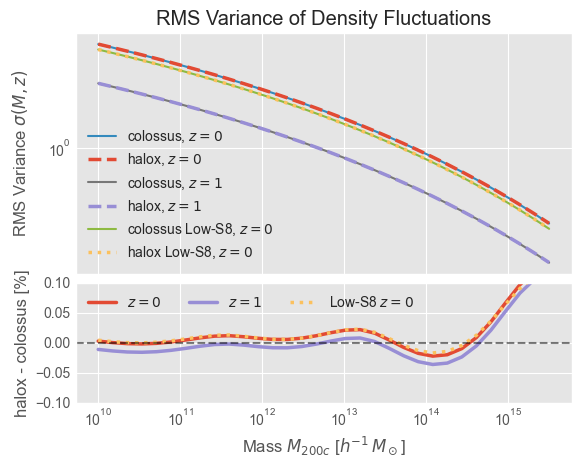

In [17]:
# Mass range and redshifts
masses = jnp.logspace(10, 15.5, 32)  # h-1 Msun
redshifts = [0.0, 1.0]

# Compute sigma values for both redshifts and cosmologies
sigma_halox_planck = {}
sigma_halox_alt = {}
sigma_colossus_planck = {}
sigma_colossus_alt = {}


@jax.jit
def compute_sigma_halox(masses, z, cosmo):
    """JIT-compiled batch computation of sigma values"""
    R = lss.mass_to_lagrangian_radius(masses, cosmo)
    return lss.sigma_R(R, z, cosmo)


for z in redshifts:
    # Planck cosmology
    sigma_halox_planck[z] = compute_sigma_halox(masses, z, cosmo_halox_planck)
    cosmo_col_obj_planck = cc.setCosmology(cosmo_colossus_planck)
    sigma_colossus_planck[z] = cosmo_col_obj_planck.sigma(
        peaks.lagrangianR(masses), z=z
    )

    # Alternative cosmology
    sigma_halox_alt[z] = compute_sigma_halox(masses, z, cosmo_halox_alt)
    cosmo_col_obj_alt = cc.setCosmology(cosmo_colossus_alt)
    sigma_colossus_alt[z] = cosmo_col_obj_alt.sigma(
        peaks.lagrangianR(masses), z=z
    )

# Reset to Planck cosmology for subsequent cells
cc.setCosmology(cosmo_colossus_planck)

# Create comparison plot
fig, ax_main, ax_ratio = create_comparison_plot()

# Main panel: plot colossus first (behind), then halox (on top)
# Original Planck cosmology comparisons - z=0.0
ax_main.loglog(
    masses, sigma_colossus_planck[0.0], label="colossus, $z=0$", **style_kw[0]
)
ax_main.loglog(
    masses, sigma_halox_planck[0.0], label="halox, $z=0$", **style_kw[1]
)

# Original Planck cosmology comparisons - z=1.0
ax_main.loglog(
    masses, sigma_colossus_planck[1.0], label="colossus, $z=1$", **style_kw[2]
)
ax_main.loglog(
    masses, sigma_halox_planck[1.0], label="halox, $z=1$", **style_kw[3]
)

# Alternative cosmology - z=0 only
ax_main.loglog(
    masses,
    sigma_colossus_alt[0.0],
    label="colossus Low-S8, $z=0$",
    **style_kw[4],
)
ax_main.loglog(
    masses, sigma_halox_alt[0.0], label="halox Low-S8, $z=0$", **style_kw[5]
)

ax_main.set_ylabel(r"RMS Variance $\sigma(M,z)$")
ax_main.set_title("RMS Variance of Density Fluctuations")
ax_main.legend()

# Ratio panel: relative differences
# Planck cosmology ratios
ratio_planck_z0 = (
    sigma_halox_planck[0.0] / sigma_colossus_planck[0.0] - 1.0
) * 100
ratio_planck_z1 = (
    sigma_halox_planck[1.0] / sigma_colossus_planck[1.0] - 1.0
) * 100

# Alternative cosmology ratio (z=0 only)
ratio_alt_z0 = (sigma_halox_alt[0.0] / sigma_colossus_alt[0.0] - 1.0) * 100

ax_ratio.semilogx(masses, ratio_planck_z0, label="$z=0$", **style_kw[-3])
ax_ratio.semilogx(masses, ratio_planck_z1, label="$z=1$", **style_kw[-2])
ax_ratio.semilogx(masses, ratio_alt_z0, label="Low-S8 $z=0$", **style_kw[-1])

ax_ratio.axhline(0.0, color="k", linestyle="--", alpha=0.5)
ax_ratio.set_xlabel(r"Mass $M_{200c}$ [$h^{-1} \, M_\odot$]")
ax_ratio.set_ylabel("halox - colossus [%]")
ax_ratio.set_ylim(-0.1, 0.1)
ax_ratio.legend(ncol=3)

# Align y-axis labels
fig.align_labels([ax_main, ax_ratio])

### Tinker08 Multiplicity Function f(σ)

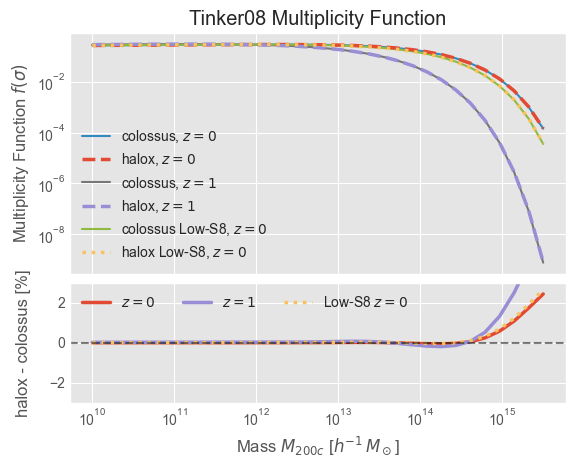

In [18]:
# Mass range and redshifts
masses = jnp.logspace(10, 15.5, 32)  # h-1 Msun
redshifts = [0.0, 1.0]
delta_c = 200.0

# JIT-compiled functions for f(sigma) computation
halox_compute_f_sigma = jax.jit(hmf.tinker08_f_sigma)

# Compute f(sigma) for both redshifts and cosmologies
f_sigma_halox_planck = {}
f_sigma_halox_alt = {}
f_sigma_colossus_planck = {}
f_sigma_colossus_alt = {}

for z in redshifts:
    # Planck cosmology
    f_sigma_halox_planck[z] = halox_compute_f_sigma(
        masses, z, cosmo_halox_planck, delta_c
    )
    cc.setCosmology(cosmo_colossus_planck)
    f_sigma_colossus_planck[z] = mass_function.massFunction(
        masses,
        z,
        mdef=f"{delta_c:.0f}c",
        model="tinker08",
        q_in="M",
        q_out="f",
    )

    # Alternative cosmology
    f_sigma_halox_alt[z] = halox_compute_f_sigma(
        masses, z, cosmo_halox_alt, delta_c
    )
    cc.setCosmology(cosmo_colossus_alt)
    f_sigma_colossus_alt[z] = mass_function.massFunction(
        masses,
        z,
        mdef=f"{delta_c:.0f}c",
        model="tinker08",
        q_in="M",
        q_out="f",
    )

# Reset to Planck cosmology
cc.setCosmology(cosmo_colossus_planck)

# Create comparison plot
fig, ax_main, ax_ratio = create_comparison_plot()

# Main panel: plot colossus first (behind), then halox (on top)
# Original Planck cosmology comparisons - z=0.0
ax_main.loglog(
    masses,
    f_sigma_colossus_planck[0.0],
    label="colossus, $z=0$",
    **style_kw[0],
)
ax_main.loglog(
    masses, f_sigma_halox_planck[0.0], label="halox, $z=0$", **style_kw[1]
)

# Original Planck cosmology comparisons - z=1.0
ax_main.loglog(
    masses,
    f_sigma_colossus_planck[1.0],
    label="colossus, $z=1$",
    **style_kw[2],
)
ax_main.loglog(
    masses, f_sigma_halox_planck[1.0], label="halox, $z=1$", **style_kw[3]
)

# Alternative cosmology - z=0 only
ax_main.loglog(
    masses,
    f_sigma_colossus_alt[0.0],
    label="colossus Low-S8, $z=0$",
    **style_kw[4],
)
ax_main.loglog(
    masses, f_sigma_halox_alt[0.0], label="halox Low-S8, $z=0$", **style_kw[5]
)

ax_main.set_ylabel(r"Multiplicity Function $f(\sigma)$")
ax_main.set_title("Tinker08 Multiplicity Function")
ax_main.legend()

# Ratio panel: relative differences
# Planck cosmology ratios
ratio_planck_z0 = (
    f_sigma_halox_planck[0.0] / f_sigma_colossus_planck[0.0] - 1.0
) * 100
ratio_planck_z1 = (
    f_sigma_halox_planck[1.0] / f_sigma_colossus_planck[1.0] - 1.0
) * 100

# Alternative cosmology ratio (z=0 only)
ratio_alt_z0 = (f_sigma_halox_alt[0.0] / f_sigma_colossus_alt[0.0] - 1.0) * 100

ax_ratio.semilogx(masses, ratio_planck_z0, label="$z=0$", **style_kw[-3])
ax_ratio.semilogx(masses, ratio_planck_z1, label="$z=1$", **style_kw[-2])
ax_ratio.semilogx(masses, ratio_alt_z0, label="Low-S8 $z=0$", **style_kw[-1])

ax_ratio.axhline(0.0, color="k", linestyle="--", alpha=0.5)
ax_ratio.set_xlabel(r"Mass $M_{200c}$ [$h^{-1} \, M_\odot$]")
ax_ratio.set_ylabel("halox - colossus [%]")
ax_ratio.set_ylim(-3, 3)
ax_ratio.legend(ncol=3)

# Align y-axis labels
fig.align_labels([ax_main, ax_ratio])

### Tinker08 Mass Function dn/d ln M

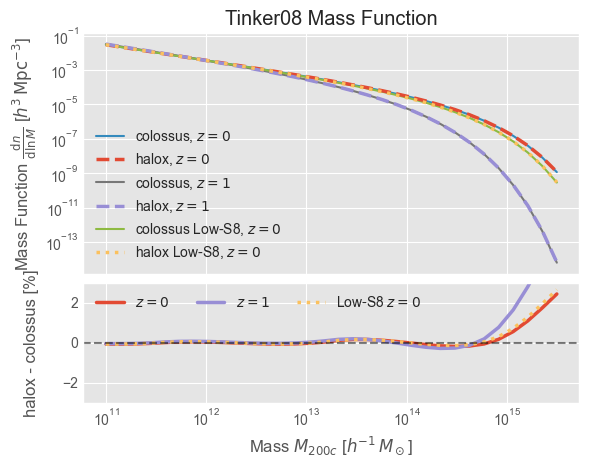

In [19]:
# Mass range and redshifts
masses = jnp.logspace(11, 15.5, 32)  # h-1 Msun
redshifts = [0.0, 1.0]
delta_c = 200.0

# JIT-compiled function for mass function computation
halox_compute_hmf = jax.jit(hmf.tinker08_mass_function)

# Compute mass functions for both redshifts and cosmologies
dn_dlnM_halox_planck = {}
dn_dlnM_halox_alt = {}
dn_dlnM_colossus_planck = {}
dn_dlnM_colossus_alt = {}

for z in redshifts:
    # Planck cosmology
    dn_dlnM_halox_planck[z] = halox_compute_hmf(
        masses, z, cosmo_halox_planck, delta_c
    )
    cc.setCosmology(cosmo_colossus_planck)
    dn_dlnM_colossus_planck[z] = mass_function.massFunction(
        masses,
        z,
        mdef=f"{delta_c:.0f}c",
        model="tinker08",
        q_in="M",
        q_out="dndlnM",
    )

    # Alternative cosmology
    dn_dlnM_halox_alt[z] = halox_compute_hmf(
        masses, z, cosmo_halox_alt, delta_c
    )
    cc.setCosmology(cosmo_colossus_alt)
    dn_dlnM_colossus_alt[z] = mass_function.massFunction(
        masses,
        z,
        mdef=f"{delta_c:.0f}c",
        model="tinker08",
        q_in="M",
        q_out="dndlnM",
    )

# Reset to Planck cosmology
cc.setCosmology(cosmo_colossus_planck)

# Create comparison plot
fig, ax_main, ax_ratio = create_comparison_plot()

# Main panel: plot colossus first (behind), then halox (on top)
# Original Planck cosmology comparisons - z=0.0
ax_main.loglog(
    masses,
    dn_dlnM_colossus_planck[0.0],
    label="colossus, $z=0$",
    **style_kw[0],
)
ax_main.loglog(
    masses, dn_dlnM_halox_planck[0.0], label="halox, $z=0$", **style_kw[1]
)

# Original Planck cosmology comparisons - z=1.0
ax_main.loglog(
    masses,
    dn_dlnM_colossus_planck[1.0],
    label="colossus, $z=1$",
    **style_kw[2],
)
ax_main.loglog(
    masses, dn_dlnM_halox_planck[1.0], label="halox, $z=1$", **style_kw[3]
)

# Alternative cosmology - z=0 only
ax_main.loglog(
    masses,
    dn_dlnM_colossus_alt[0.0],
    label="colossus Low-S8, $z=0$",
    **style_kw[4],
)
ax_main.loglog(
    masses, dn_dlnM_halox_alt[0.0], label="halox Low-S8, $z=0$", **style_kw[5]
)

ax_main.set_ylabel(
    r"Mass Function $\frac{{\rm d}n}{{\rm d}\ln M}$ [$h^3 \, {\rm Mpc}^{-3}$]"
)
ax_main.set_title("Tinker08 Mass Function")
ax_main.legend()

# Ratio panel: relative differences
# Planck cosmology ratios
ratio_planck_z0 = (
    dn_dlnM_halox_planck[0.0] / dn_dlnM_colossus_planck[0.0] - 1.0
) * 100
ratio_planck_z1 = (
    dn_dlnM_halox_planck[1.0] / dn_dlnM_colossus_planck[1.0] - 1.0
) * 100

# Alternative cosmology ratio (z=0 only)
ratio_alt_z0 = (dn_dlnM_halox_alt[0.0] / dn_dlnM_colossus_alt[0.0] - 1.0) * 100

ax_ratio.semilogx(masses, ratio_planck_z0, label="$z=0$", **style_kw[-3])
ax_ratio.semilogx(masses, ratio_planck_z1, label="$z=1$", **style_kw[-2])
ax_ratio.semilogx(masses, ratio_alt_z0, label="Low-S8 $z=0$", **style_kw[-1])

ax_ratio.axhline(0.0, color="k", linestyle="--", alpha=0.5)
ax_ratio.set_xlabel(r"Mass $M_{200c}$ [$h^{-1} \, M_\odot$]")
ax_ratio.set_ylabel("halox - colossus [%]")
ax_ratio.set_ylim(-3, 3)
ax_ratio.legend(ncol=3)

# Align y-axis labels
fig.align_labels([ax_main, ax_ratio])

### Tinker10 Halo Bias

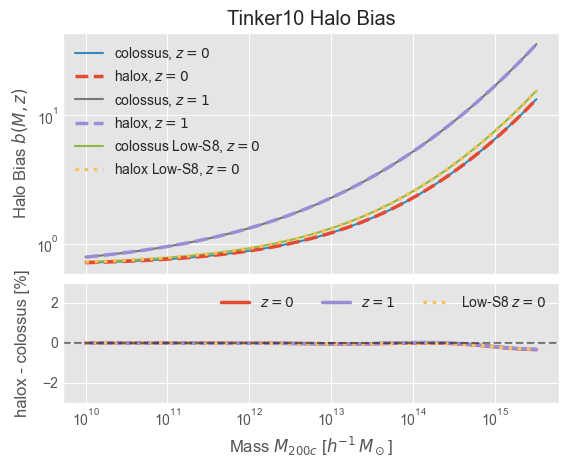

In [20]:
# Mass range and redshifts
masses = jnp.logspace(10, 15.5, 32)  # h-1 Msun
redshifts = [0.0, 1.0]
delta_c = 200.0

# JIT-compiled function for halo bias computation
halox_compute_bias = jax.jit(bias.tinker10_bias)

# Compute halo bias for both redshifts and cosmologies
bias_halox_planck = {}
bias_halox_alt = {}
bias_colossus_planck = {}
bias_colossus_alt = {}

for z in redshifts:
    # Planck cosmology
    bias_halox_planck[z] = halox_compute_bias(
        masses, z, cosmo_halox_planck, delta_c
    )
    cc.setCosmology(cosmo_colossus_planck)
    bias_colossus_planck[z] = colossus_bias.haloBias(
        masses, z, mdef=f"{delta_c:.0f}c", model="tinker10"
    )

    # Alternative cosmology
    bias_halox_alt[z] = halox_compute_bias(masses, z, cosmo_halox_alt, delta_c)
    cc.setCosmology(cosmo_colossus_alt)
    bias_colossus_alt[z] = colossus_bias.haloBias(
        masses, z, mdef=f"{delta_c:.0f}c", model="tinker10"
    )

# Reset to Planck cosmology
cc.setCosmology(cosmo_colossus_planck)

# Create comparison plot
fig, ax_main, ax_ratio = create_comparison_plot()

# Main panel: plot colossus first (behind), then halox (on top)
# Original Planck cosmology comparisons - z=0.0
ax_main.loglog(
    masses, bias_colossus_planck[0.0], label="colossus, $z=0$", **style_kw[0]
)
ax_main.loglog(
    masses, bias_halox_planck[0.0], label="halox, $z=0$", **style_kw[1]
)

# Original Planck cosmology comparisons - z=1.0
ax_main.loglog(
    masses, bias_colossus_planck[1.0], label="colossus, $z=1$", **style_kw[2]
)
ax_main.loglog(
    masses, bias_halox_planck[1.0], label="halox, $z=1$", **style_kw[3]
)

# Alternative cosmology - z=0 only
ax_main.loglog(
    masses,
    bias_colossus_alt[0.0],
    label="colossus Low-S8, $z=0$",
    **style_kw[4],
)
ax_main.loglog(
    masses, bias_halox_alt[0.0], label="halox Low-S8, $z=0$", **style_kw[5]
)

ax_main.set_ylabel(r"Halo Bias $b(M,z)$")
ax_main.set_title("Tinker10 Halo Bias")
ax_main.legend()

# Ratio panel: relative differences
# Planck cosmology ratios
ratio_planck_z0 = (
    bias_halox_planck[0.0] / bias_colossus_planck[0.0] - 1.0
) * 100
ratio_planck_z1 = (
    bias_halox_planck[1.0] / bias_colossus_planck[1.0] - 1.0
) * 100

# Alternative cosmology ratio (z=0 only)
ratio_alt_z0 = (bias_halox_alt[0.0] / bias_colossus_alt[0.0] - 1.0) * 100

ax_ratio.semilogx(masses, ratio_planck_z0, label="$z=0$", **style_kw[-3])
ax_ratio.semilogx(masses, ratio_planck_z1, label="$z=1$", **style_kw[-2])
ax_ratio.semilogx(masses, ratio_alt_z0, label="Low-S8 $z=0$", **style_kw[-1])

ax_ratio.axhline(0.0, color="k", linestyle="--", alpha=0.5)
ax_ratio.set_xlabel(r"Mass $M_{200c}$ [$h^{-1} \, M_\odot$]")
ax_ratio.set_ylabel("halox - colossus [%]")
ax_ratio.set_ylim(-3, 3)
ax_ratio.legend(ncol=3)

# Align y-axis labels
fig.align_labels([ax_main, ax_ratio])